Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import cv2
import zipfile
import os

Load the zipped data file of the specified type.

In [0]:
dataset = "BOW"

In [0]:
if not(os.path.exists(dataset)):
  with zipfile.ZipFile(dataset + ".zip", 'r') as zip_ref:
    zip_ref.extractall("")

In [0]:
# Load data
with open(dataset + "/X.pkl", "rb") as f:
  X = pickle.load(f)

with open(dataset + "/y.pkl", "rb") as f:
  y = pickle.load(f)

X = X.to('cuda').float()
y = y.to('cuda').float()
y = (y> 10).float()

In [0]:
indices = np.arange(0, X.shape[0])
np.random.shuffle(indices)
train_indices = indices[:(X.shape[0] - 1000)]
test_indices = indices[(X.shape[0] - 1000):]

y_train = y[train_indices]
y_test = y[test_indices]
X_train = X[train_indices, :, :]
X_test = X[test_indices, :, :]

Define an RNN architecture for modelling.

In [0]:
# Define the network as a class
class RNNNetwork(torch.nn.Module):

    def __init__(self, input_size):
        super(RNNNetwork, self).__init__()
        
        #  Recurrent (sequence) layer
        self.lstm = torch.nn.LSTM(input_size, 25)

        # Two linear layers
        self.linear1 = torch.nn.Linear(100, 25)
        self.linear2 = torch.nn.Linear(25, 1)

        # Dropout of 50% of values
        self.dropout = torch.nn.Dropout(0.5)

        # Sigmoid activation
        self.sigmoid = torch.nn.Sigmoid()

    # Performs the forward pass
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        #out = self.linear1(out.view(len(x), -1))
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out[len(x)-1]

In [0]:
# Declare a model and prepare for training
rnn_model = RNNNetwork(X_train.shape[2])
rnn_model.to('cuda')
rnn_model.train(True)
rnn_model.float()

# Use the mse loss for a criterion
criterion = torch.nn.MSELoss()

# Define the adam optimizer on the discriminator network
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.000001,
                                 betas=(0.9, 0.9999))


Train the model:

In [0]:
# Save the losses
losses_train = []
losses_test = []
epochs = 100

# Use  100 epochs
for i in range(0, epochs+1):
    
    # Every tenth iteration
    if (i % 10 == 0):

      # Track the epoch count
      print(i, " of ", epochs)

      # Get loss on the training data
      epoch_losses_train = []
      for j in range(0, int(X_train.shape[0])):
      
          # Zero the  gradient
          rnn_optimizer.zero_grad()

          # Select inputs
          train_input = X_train[j:(j+1),:, :]
          train_input = X_train[(j):(j+1),:((np.where(train_input.sum(axis=2).cpu().numpy() != -300))[1]).max(), :]
          train_input = train_input.reshape(train_input.shape[1], 1, train_input.shape[2])

          # Skip this input if needed
          if train_input.shape[0] == 0:
            continue

          # Get outputs and truth
          train_output = rnn_model(train_input)
          true_output = y_train[j:(j+1)]
          
          # Calculate the loss and update the model
          loss = criterion(train_output, true_output)
          loss.backward()
          rnn_optimizer.step()

          # Save the loss for this training iteration
          epoch_losses_train.append(loss)

      # Set training to false
      rnn_model.train(False)

      # Get loss on the testing data
      epoch_losses_test = []
      for j in range(0, int(X_test.shape[0])):

          # Select inputs
          train_input = X_test[j:(j+1),:, :]
          train_input = X_test[(j):(j+1),:((np.where(train_input.sum(axis=2).cpu().numpy() != -300))[1]).max(), :]
          train_input = train_input.reshape(train_input.shape[1], 1, train_input.shape[2])

          # Sip if neceeded
          if train_input.shape[0] == 0:
            continue

          # Get outputs and truth
          train_output = rnn_model(train_input)
          true_output = y_test[j:(j+1)]
          
          # Calculate the save the loss, but don't update the model
          loss = criterion(train_output, true_output)
          epoch_losses_test.append(loss)

      # Save the losses
      losses_train.append((sum(epoch_losses_train) / len(epoch_losses_train)).sqrt())
      losses_test.append((sum(epoch_losses_test) / len(epoch_losses_test)).sqrt())

      # Allow model to train on the next iterations
      rnn_model.train(True)
    
    else:

      # Go across the entire dataset
      for j in range(0, int(X_train.shape[0])):
      
          # Zero the  gradient
          rnn_optimizer.zero_grad()

          # Select inputs
          train_input = X_train[j:(j+1),:, :]
          train_input = X_train[(j):(j+1),:((np.where(train_input.sum(axis=2).cpu().numpy() != -300))[1]).max(), :]
          train_input = train_input.reshape(train_input.shape[1], 1, train_input.shape[2])

          # Skip 0 length sequences
          if train_input.shape[0] == 0:
            continue

          # Get hte training output
          train_output = rnn_model(train_input)
          true_output = y_train[j:(j+1)]
          
          # Calculate the loss and update the model
          loss = criterion(train_output, true_output)
          loss.backward()
          rnn_optimizer.step()

0  of  100


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


10  of  100
20  of  100
30  of  100
40  of  100
50  of  100
60  of  100
70  of  100
80  of  100
90  of  100
100  of  100


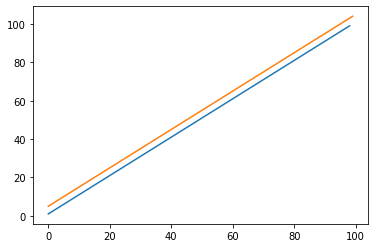

In [3]:
# Plot the training /testing losses
plt.plot(np.arange(1, 100)) #losses_train_plot)
plt.plot(np.arange(5, 105)) #losses_test_plot)

Evaluate the model on both training and testing data:

In [0]:
# Turn training off
rnn_model.train(False)

# Track accuracies
accuracy_train = []
for j in range(0, int(X_train.shape[0])):

    # Select inputs
    train_input = X_train[j:(j+1),:, :]
    train_input = X_train[(j):(j+1),:((np.where(train_input.sum(axis=2).cpu().numpy() != -300))[1]).max(), :]
    train_input = train_input.reshape(train_input.shape[1], 1, train_input.shape[2])

    # Skip if 0 length
    if train_input.shape[0] == 0:
      continue

    # Calculate hte model output
    train_output = rnn_model(train_input)
    true_output = y_train[j:(j+1)]

    # Check if it was correct
    correct = (train_output > 0.5) == true_output
    accuracy_train.append(correct.float())

# Do same on testing data
accuracy_test = []
for j in range(0, int(X_test.shape[0])):

    # Select inputs
    train_input = X_test[j:(j+1),:, :]
    train_input = X_test[(j):(j+1),:((np.where(train_input.sum(axis=2).cpu().numpy() != -300))[1]).max(), :]
    train_input = train_input.reshape(train_input.shape[1], 1, train_input.shape[2])

    if train_input.shape[0] == 0:
      continue

    if train_input.shape[0] == 0:
      continue

    train_output = rnn_model(train_input)
    true_output = y_train[j:(j+1)]

    correct = (train_output > 0.5) == true_output
    accuracy_test.append(correct.float())

# Calculate overall accuracies
print((sum(accuracy_train)[0][0]) / len(accuracy_train))
print((sum(accuracy_test)[0][0]) / len(accuracy_test))

tensor(0.8324, device='cuda:0')
tensor(0.8260, device='cuda:0')


In [0]:
# Calculate accuracies if only guessed 0
accuracy_naive = []
for j in range(0, int(X_test.shape[0])):

    train_output = 0
    true_output = y_test[j:(j+1)]
    
    loss = (train_output > 0.5) == true_output
    accuracy_naive.append(loss.float())
print(sum(accuracy_naive) / len(accuracy_naive))

tensor([0.8200], device='cuda:0')


Build an MLP for the same purpose.

In [0]:
# Define the network as a class for convenience
class LinearNetwork(torch.nn.Module):

    def __init__(self, input_size):
        super(LinearNetwork, self).__init__()
        
        # 5 linear layers
        self.linear1 = torch.nn.Linear(input_size, 1024)
        self.linear2 = torch.nn.Linear(1024, 256)
        self.linear3 = torch.nn.Linear(256, 64)
        self.linear4 = torch.nn.Linear(64, 16)
        self.linear5 = torch.nn.Linear(16, 1)

        # Use sigmoid activation between each layer
        self.activation = torch.nn.Sigmoid()
        
    # Performs the forward pass
    def forward(self, x):

        out = self.linear1(x)
        out = self.activation(out)
        
        out = self.linear2(out)
        out = self.activation(out)
        
        out = self.linear3(out)
        out = self.activation(out)
        
        out = self.linear4(out)
        out = self.activation(out)
        
        out = self.linear5(out)
        return out

For bag of words, collapse along sequence axis (will throw memory error otherwise). If not, just reeshape to a 2 dimensional matrix.

In [0]:
if dataset == "BOW":
  X_train = X_train.sum(axis=1)
  X_test = X_test.sum(axis=1)
else:
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [0]:
Training the model

In [0]:
# Defines a model and prepare for training
linear_model = LinearNetwork(X_train.shape[1])
linear_model.to('cuda')
linear_model.train(True)
linear_model.float()

# Use the mse loss for a criterion
criterion = torch.nn.MSELoss()

# Define the adam optimizer on the discriminator network
linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.001,
                                 betas=(0.9, 0.9999))


In [0]:
# Save the losses
losses_train = []
losses_test = []
epochs = 100

# Use  100 epochs
for i in range(0, epochs+1):
    
    # Every tenth iteration
    if (i % 10 == 0):

      # Track the epoch count
      print(i, " of ", epochs)

      # Get loss on the training data
      epoch_losses_train = []
      for j in range(0, int(X_train.shape[0])):
      
          # Zero the  gradient
          linear_optimizer.zero_grad()

          # Select inputs
          train_input = X_train[j:(j+1),:]
          
          # Skip this input if needed
          if train_input.shape[0] == 0:
            continue

          # Get outputs and truth
          train_output = linear_model(train_input)
          true_output = y_train[j:(j+1)]
          
          # Calculate the loss and update the model
          loss = criterion(train_output, true_output)
          loss.backward()
          linear_optimizer.step()

          # Save the loss for this training iteration
          epoch_losses_train.append(loss)

      # Set training to false
      linear_model.train(False)

      # Get loss on the testing data
      epoch_losses_test = []
      for j in range(0, int(X_test.shape[0])):

          # Select inputs
          train_input = X_test[j:(j+1),:]
          #train_input = train_input.reshape(1, train_input.shape[1] * train_input.shape[2])

          # Sip if neceeded
          if train_input.shape[0] == 0:
            continue

          # Get outputs and truth
          train_output = linear_model(train_input)
          true_output = y_test[j:(j+1)]
          
          # Calculate the save the loss, but don't update the model
          loss = criterion(train_output, true_output)
          epoch_losses_test.append(loss)

      # Save the losses
      losses_train.append((sum(epoch_losses_train) / len(epoch_losses_train)).sqrt())
      losses_test.append((sum(epoch_losses_test) / len(epoch_losses_test)).sqrt())

      # Allow model to train on the next iterations
      linear_model.train(True)
    
    else:

      # Go across the entire dataset
      for j in range(0, int(X_train.shape[0])):
      
          # Zero the  gradient
          linear_optimizer.zero_grad()

          # Select inputs
          train_input = X_train[j:(j+1),:]
          #train_input = train_input.reshape(1, train_input.shape[1] * train_input.shape[2])

          if train_input.shape[0] == 0:
            continue

          train_output = linear_model(train_input)
          true_output = y_train[j:(j+1)]
          
          loss = criterion(train_output, true_output)
          loss.backward()
          linear_optimizer.step()

0  of  100


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


10  of  100
20  of  100
30  of  100
40  of  100
50  of  100
60  of  100
70  of  100
80  of  100
90  of  100
100  of  100


Also evaluate this model on the training / testing datasets, using the same method as the last one.

In [0]:
linear_model.train(False)

accuracy_train = []
for j in range(0, int(X_train.shape[0])):

    # Select inputs
    train_input = X_train[j:(j+1),:]

    if train_input.shape[0] == 0:
      continue

    train_output = linear_model(train_input)
    true_output = y_train[j:(j+1)]

    correct = (train_output > 0.5) == true_output
    accuracy_train.append(correct.float())

accuracy_test = []
for j in range(0, int(X_test.shape[0])):

    # Select inputs
    train_input = X_test[j:(j+1),:]

    if train_input.shape[0] == 0:
      continue

    train_output = linear_model(train_input)
    true_output = y_train[j:(j+1)]

    correct = (train_output > 0.5) == true_output
    accuracy_test.append(correct.float())

print((sum(accuracy_train)[0][0]) / len(accuracy_train))
print((sum(accuracy_test)[0][0]) / len(accuracy_test))

tensor(0.8324, device='cuda:0')
tensor(0.8260, device='cuda:0')
